# Fitting SN 1a data to $\Lambda$CDM and CPL models with emcee 

The following notebook demonstrates the use of the emcee package in cosmology using Supernovae 1a data from the Union 2.1 and Pantheon collections. Emcee is a lightweight python package for MCMC applications. It proves to be a powerful tool for Bayesian statistics. Aim of this example is to constrain the cosmological parameters in the $\Lambda$CDM model and the CPL model namely $\Omega_m$ the proportion of matter and dark matter in the universe as well as the equation of state parameters $w_0$ and $w_1$ with the Union 2.1 and the Pantheon data. Additionally, we investigate the effect of prior probabilities on the outcome by adopting CMB priors from Planck 2018.

### Theoretical models

Supernovae 1a events have the great advantage of being extremely uniform. If one measures the redshift of the radiation and relates this to the apparent brightness of the event, conclusions can be drawn about the composition of our universe. The Hubble function characterising the expansion of the universe as a function of redshift $\lambda_{emit}/\lambda_{obs} = 1 + z$ for the two models considered is as follows
\begin{align}
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m) (1+z)^{3 (1+w_0+w_1)} \exp\left\{-\frac{3w_1}{1+z}\right\}}
\end{align}
In the $\Lambda$CDM model $w_0$ and $w_1$ are fixed to $w_0 = -1$ and $w_1 = 0$. For $CPL$ they are free parameters.


### Bayesian methods

The latent variables are determined by maximizing the posterior probability, i.e. the probability of the data been generated by a set of variables. Oftentimes and also in this case only the likelihood probability is know, i.e. the probability distribution of the data given a set of specific variables. Fortunately the two are connected via Bayes' Theorem.

\begin{align}
P(\theta \mid D) = \frac{P(D \mid \theta) P(\theta)}{P(D)}
\end{align}

The great advantage of MCMC algorithms is that the normalization constant, the evidence $P(D)$ don't have to be known. Additionally in the most cases it is guaranteed to sample from the maximum posterior distrbution if one waits long enough. 

Ones the maximum posterior distrbution is know, i.e. we have samples from it, the distribution of each parameter can be determined via marginalization. 

\begin{align}
P(\theta_k \mid D) = \int P(\theta \mid D) d\theta_1 \cdots d \theta_{k-1} d \theta_{k-1} \cdots d \theta_{n}
\end{align}

This is done through Monte-Carlo-Integration which is basically counting.


### Importing packages and setting rcParams

In the first step it is necessary to import all the needed packages. As one can see, apart from emcee only numpy is mandatory for the MCMC. Matplotlib and Corner are needed for the plotting routine and cosmo module which provides the needed data classes for the Pantheon and Union data as well as the cosmological functions our models are based on.

In [157]:
import emcee as em
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.lines as mlines
from cosmo_jnp import cosmo, data, pantheon
from IPython.display import display

In [158]:
plt.style.use('default')
plt.rcParams['font.size'] = 16.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 0.4
plt.rcParams['lines.linewidth'] = 0.8
rc('text', usetex=True)

### Importing data

The import of the data is done automatically by passing the .txt files in the data class (Union) and the Pantheon class (Pantheon). 

In [159]:
#import data. The d denotes the union 2.1 data, p pantheon data and tot is the combined data. 
#inv stands for the inverse covariance matrix

d = data('union2.txt', 'union2_covsys.txt')
d_inv = d.inv_cov
d_cov = jnp.linalg.inv(d_inv)
p = pantheon('pantheon.txt', 'pantheon_covsys.txt')
p_inv = p.inv_cov
p_cov = jnp.linalg.inv(p_inv)
tot_red = np.concatenate((d.redshift, p.redshift1))
tot_dm = np.concatenate((d.dm, p.dm))
tot_err = np.concatenate((d.err, p.err))
tot_cov = jnp.linalg.inv(tot_inv)
d_num = len(d.dm)
p_num = len(p.dm)
tot_inv = np.block([[d_inv, np.zeros((d_num, p_num))],
                   [np.zeros((p_num, d_num)), p_inv]])

union_dict = {'x' : d.redshift, 'y' : d.dm, 'inv_cov' : d_inv, 'name':'union'}
panth_dict = {'x' : p.redshift1, 'y' : p.dm, 'inv_cov' : p_inv, 'name':'panth'}
total_dict = {'x' : tot_red, 'y' : tot_dm, 'inv_cov' : tot_inv, 'name':'total'}

### Visualizing the data

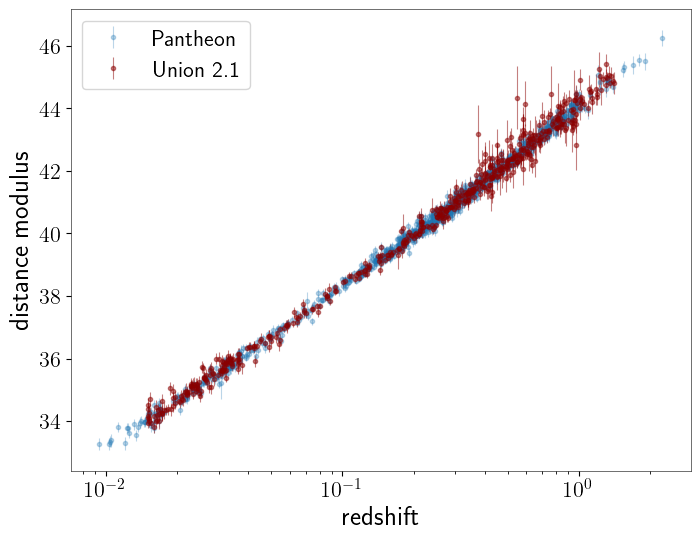

In [6]:
fig1, ax1 = plt.subplots(1,1, figsize=(8,6))
ax1.errorbar(p.redshift1, p.dm, p.err, linestyle='', marker='.', elinewidth=0.8, label='Pantheon', alpha=0.3)
ax1.errorbar(d.redshift, d.dm, d.err, linestyle='', marker='.', elinewidth=0.8, label='Union 2.1', alpha=0.5, color='darkred')
ax1.set_xlabel(r'redshift')
ax1.set_ylabel('distance modulus')
ax1.set_xscale('log')
ax1.legend();

Different cosmologies have to be initialized. ℎ
is chosen as 0.7 as in required to use the calculated distance moduli. The cosmo class also takes the redshift as an argument to precompute a matrix for faster evaluation. Thus, it is needed to set a different cosmology for every data set. Albeit this makes this very problem specific, the advantages in time are significant which makes it worth the effort.

In [7]:
cosmology1 = cosmo(0.7, d.redshift)
cosmology2 = cosmo(0.7, p.redshift1)
cosmology3 = cosmo(0.7, tot_red)

Next the likelihood and the prior need to be set up. Only the logarithm is used. This is required for emcee and has the effect that instead of the prooduct only the sum has to be build. And since the evidence term as a normalisation constant is unknown there is an additive constant which is not needed to be taken into account.

A gaussian likelihood is to be assumed and the distance modulus is computed via a method of the cosmo class.

For these purposes only the logarithms of the probabilities are considered due to the fact that optimizing the log-probability is equivalent to optimizing the probability and working with very small number which occur likely can yield numerical instabilities.

In [8]:
def log_likelihood(y, cov, cosm, Omega_m=0.3, w_0=-1, w_1=0, a=0,):
    distance_mod = cosm.dist_mod(Omega_m, w_0, w_1, a)
    log_like = -0.5 * ((y - distance_mod) @ cov @ (y - distance_mod))
    #log_like = - 0.5 * np.sum(((y-distance_mod)/cov.err)**2)
    return log_like

The priors assumed here are no priors in the first case despite the fact, that $\Omega_m$ has to be between $0\%$ and $100\%$ and priors found at the 2018 Planck CMB observation $\Omega_m = 0.3166 \pm 0.0084$, $w_0 = 0.957 \pm 0.08$ and $w_1 = 0.32 \pm 0.29$ all gaussian distributed. This is in fact not the case. The prior value for $w_1$ is slightly asymmetrical and was symmetrised for this purpose.

It need to be taken into account that their is a different underlying cosmolgy since $h$ has no fixed value in the CMB calculations due to the fact that $H_0$ is also determined through the experimental data which is not possible with the SN 1a data alone. This could be fixed by calculating the cosmology more general e.g. via the monthepython package.

In [9]:
def log_prior(Omega_m=0.3, w_0=-1, w_1=0, a=0):
    '''returns the log of the propability densities up to a constant'''
    if 0.0 < Omega_m < 1:
        return -((w_0+1)**2/5**2 + (w_1)**2/5**2 + a**2/5**2) 
    return -np.inf

In [10]:
def log_probability(theta, y, cov, cosm):
    '''performs the multiplication prior*likelihood'''
    keys = ['Omega_m', 'w_0', 'w_1', 'a']
    theta_dict = dict(zip(keys, theta))
    lp = log_prior(**theta_dict)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood( y, cov, cosm,**theta_dict)

In [210]:
def log_prior_planck(Omega_m, w_0=-1, w_1=0, a=0):
    '''returns the log of the propability densities up to a constant'''
    l_prior = - ((Omega_m - 0.3166)**2/0.0084**2 + (w_0+0.957)**2/0.08**2 + (w_1 + 0.32)**2/0.29**2 + a**2/0.5**2) 
    return l_prior

In [211]:
def log_probability_planck(theta, y, cov, cosm):
    '''performs the multiplication prior*likelihood'''
    keys = ['Omega_m', 'w_0', 'w_1', 'a']
    theta_dict = dict(zip(keys, theta))
    lp = log_prior_planck(**theta_dict)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(y=y, cov=cov, cosm=cosm, **theta_dict)

Setting up the initial conditions. As starting values $\Omega_m = 0.5$, $w_0 = -1$ and $w_1 = 0$ are taken. The  number of walkers are $16$ and the initial values for each walker will get randomised so that the chains are independent from each other.

In [212]:
initial_lambda = np.array([0.5])
initial_cpl = np.array([0.5, -1, 0])
initial_alpha = np.array([0.5, -1, 0, 0])

Since there are different data sets as well as models and priors there will be quite a few MCMC runs to do, therefore it is useful to automize this by defining a function. 

It is a good idea to save the final result as a text in this case .gz file which numpy can handle very well since each chain take quite a while to run and the samples aren't stored in case the kernel has to be restarted.

In case emcee crashes it is wise to set up a backend, so that the problem can figured out easily.


### Setting up the sampler

Setting up the sampler is as easy as it gets. Emcee only needs the number of walkers or chains the dimension of the variable space the log probability of the unnormalized posterior and additional arguments like the observed data and the covariance.

To run the sampler only the initial conditions and the length of each chain need to be handed over. Emcee does the rest.

The above function handles everything in ones which is maybe not the 

In [54]:
def run_sampler(initial, nwalkers, log_probability, dm, data_inv, cosm, num):
    
    print(name+' started...')

    ndim = len(initial)
    pos = initial + 0.05 * np.random.randn(nwalkers, ndim) 
    

    #filename = name+"_backend.h5"
    #backend = em.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    
    sampler = em.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(dm, data_inv, cosm)#, backend=backend
    )
    sampler.run_mcmc(pos, num, progress=True);
    samples = sampler.get_chain(flat=True)
    
    
    #saving the data as a numpy-readable file is optional
    #np.savetxt('data_tables/'+name+'.gz', samples)
    
    labels = [r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"]
    var_names = labels[slice(None, ndim)]
    
    idata = az.from_emcee(sampler, var_names=var_names)
    
    return idata

In [55]:
def plot_trace(idata):
    az.plot_trace(idata)
    plt.tight_layout()
    plt.savefig('figures/'+name+'_trace.pdf')

In [81]:
def evaluate(idata, burnin, name=None):
    
    idata = idata.sel(draw=slice(burnin, None))

    display(az.summary(idata, kind='stats', hdi_prob=0.68))
    
    if name:
        with open('latex_tables/'+name+'_table.txt', 'w') as f:
            f.write(az.summary(idata, kind='stats', hdi_prob=0.68).to_latex(escape=False))

In [235]:
from typing import List, Optional
def plot_results(idata,  burnin, var_names: Optional[List[str]] = None, kde_kwargs=None,
            marginal_kwargs=None, dist_kwargs=None, ax=None, name=None, order=None):

    idata = idata.sel(draw=slice(burnin, None))
    
    if len(idata.posterior) == 1: 
        vals = np.concatenate(idata.posterior[r"$\Omega_{m,0}$"].values)
        az.plot_dist(vals, ax=ax, label=name, **dist_kwargs)
    else:
        az.plot_pair(idata, var_names=var_names, kind='kde', marginals=True, figsize=(10,10), textsize=16, ax=ax, 
                    kde_kwargs=kde_kwargs, marginal_kwargs=marginal_kwargs, contour=False)
        

In [ ]:
idata_union_lcdm = run_sampler(initial_lambda, 16, log_probability, d.dm, d_inv, cosmology1,100)

,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.328,0.074,0.254,0.357


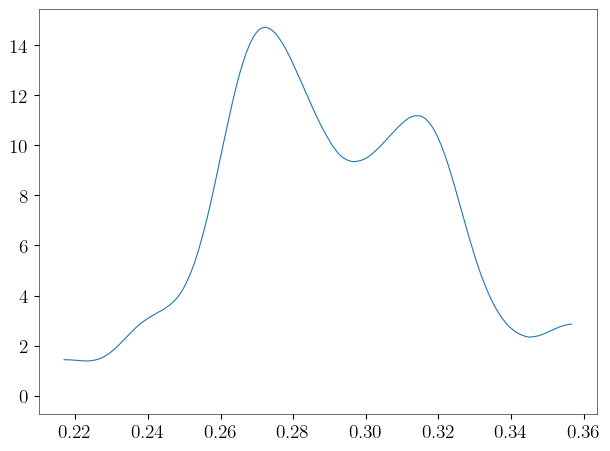

In [91]:
evaluate(idata_union_lcdm, 0)
plot_results(idata_union_lcdm, 90)

In [42]:
lcdm_dict = {'init' : initial_lambda, 'name' : 'lcdm'}
cpl_dict = {'init' : initial_cpl, 'name' : 'cpl'}
alpha_dict = {'init' : initial_alpha, 'name' : 'alpha'}

In [45]:
idata_dict = {}
for model in [lcdm_dict, cpl_dict, alpha_dict]:
    for dat in [union_dict, panth_dict, total_dict]:
        name = dat['name']+'_'+model['name']
        idata = run_sampler(model['init'], 16, log_probability, 
                                  dat['y'], dat['inv_cov'], cosmo(0.7, dat['x']), 1000, name)
        idata_dict[name] = idata

union_lcdm started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:34<00:00, 10.61it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.289,0.031,0.259,0.32


panth_lcdm started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.51it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.289,0.009,0.28,0.297


total_lcdm started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:44<00:00,  2.90it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.289,0.008,0.281,0.297


union_cpl started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.41it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.308,0.109,0.232,0.446
$w_0$,-1.129,0.352,-1.353,-0.695
$w_1$,0.005,0.015,-0.008,0.020


panth_cpl started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.275,0.098,0.218,0.407
$w_0$,-0.973,0.216,-1.184,-0.748
$w_1$,0.006,0.006,0.002,0.014


total_cpl started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:26<00:00,  2.24it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.285,0.070,0.229,0.363
$w_0$,-0.978,0.167,-1.130,-0.801
$w_1$,0.006,0.006,0.001,0.011


union_alpha started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  8.92it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.807,0.247,0.836,1.000
$w_0$,-1.860,2.251,-2.811,1.004
$w_1$,0.961,1.559,-0.137,0.846
$\alpha$,0.684,0.378,0.552,0.955


panth_alpha started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:53<00:00,  4.28it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.618,0.267,0.481,0.988
$w_0$,-0.898,1.155,-1.858,-0.229
$w_1$,0.042,0.062,-0.007,0.038
$\alpha$,0.494,0.416,-0.014,0.782


total_alpha started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:28<00:00,  2.58it/s]


,mean,sd,hdi_16%,hdi_84%
"$\Omega_{m,0}$",0.654,0.253,0.617,0.975
$w_0$,-0.779,1.028,-2.163,-0.622
$w_1$,0.050,0.073,-0.008,0.039
$\alpha$,0.521,0.488,0.283,1.051


In [214]:
for model in [alpha_dict]:
    for dat in [union_dict, panth_dict, total_dict]:
        name = dat['name']+'_'+model['name']+'_planck'
        idata = run_sampler(model['init'], 16, log_probability_planck, 
                                  dat['y'], dat['inv_cov'], cosmo(0.7, dat['x']), 1000)
        idata_dict[name] = idata

union_alpha_planck started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:09<00:00,  7.70it/s]


panth_alpha_planck started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.90it/s]


total_alpha_planck started...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:34<00:00,  2.20it/s]


In [ ]:
fig1, ax1 = plt.subplots(3,3,figsize=(8,8))
plot_results(idata_dict['union_cpl'], 100, ax=ax1, 
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds"}, "contour_kwargs": {"linewidths":0.2}},
            marginal_kwargs={"color": "darkred"})
plot_results(idata_dict['panth_cpl'], 100, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Greens"}, "contour_kwargs": {"linewidths":0.2}},
            marginal_kwargs={"color": "darkgreen"})
plot_results(idata_dict['total_cpl'], 100, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Blues"}, "contour_kwargs": {"linewidths":0.2}},
            marginal_kwargs={"color": "tab:blue"})

union = mlines.Line2D([], [], color='darkred', label='Union 2.1')
panth = mlines.Line2D([], [], color='tab:blue', label='Pantheon')
total = mlines.Line2D([], [], color='green', label='U+P')

fig1.legend(handles=(union,panth,total))

# Numpyro

In [138]:
import jax.numpy as jnp
import jax.random as random
import jax_cosmo

import numpyro
import numpyro.distributions as dist
from numpyro import sample, param, plate
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoLaplaceApproximation

import arviz as az

from optax import adam

In [139]:
#Set random state
key = random.PRNGKey(123)
key1, key2 = random.split(key)

In [140]:
def run_auto_mvnormal(model, x, y, inv_cov, name, steps=1000, num_samples=1000):
    
    cov = jnp.linalg.inv(inv_cov)
    
    guide = AutoMultivariateNormal(model)
    
    svi = SVI(model, 
          guide, 
          adam(0.01), 
          Trace_ELBO(),     
          x = x,
          y = y,
          cov = cov
    )

    svi_results = svi.run(random.PRNGKey(3141), steps)
    params = svi_results.params
    samples = guide.sample_posterior(random.PRNGKey(1235), params, (num_samples,))
    samples.pop("mu")
    print_summary(samples, 0.68, False)
    
    #fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    #ax.plot(-svi_results.losses)
    #ax.set_title("negative losses")
    #ax.set_yscale("log")
    
    var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
               "w_0" :  r"$w_0$",
               "w_1" : r"$w_1$",
               "alpha" : r"$\alpha$"}
    az_data = az.convert_to_inference_data(samples)
    az_data.rename_vars(var_dict, groups='posterior', inplace='True')
    #ndim = jnp.size(params)
    #print(ndim)
    #if ndim == 1:
    #    az.plot_density(az_data)
    #    
    #else:
    #    az.plot_pair(az_data, kind='kde', marginals=True);

    return svi_results, samples, az_data

In [167]:
def comparison(models, data_dicts, name):
    svi_data_dict = {}
    i=0
    for model in models:
        for dat in data_dicts:
            n = name[i]
            _,_, idata = run_auto_mvnormal(model, **dat, steps=2000, num_samples=1000)
            svi_data_dict[n] = [idata]
            i+=1
    
    return svi_data_dict

### $\Lambda$CDM model

We define the $\Lambda$CDM model which only depends on one parameter. The guide is defined as a nultivariate normal distribution.

In [149]:
def model_lcdm(x, y, cov):
    cosm = cosmo(0.7, x)
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    
    mu = numpyro.deterministic("mu", cosm.dist_mod(Omega_m))
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

In [150]:
def model_lcdm_planck(x, y, cov):
    cosm = cosmo(0.7, x)
    Omega_m = sample("Omega_m", dist.TruncatedNormal(0.3166,0.0084, low=0, high=1))
    mu = numpyro.deterministic("mu", cosm.dist_mod(Omega_m))
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

### CPL model

The CPL model gets defined. Note that for the sake of proper convergence it is needed in both cases to constrain the variables to a finite interval, albeit the normal distribution at least in the case of $\Omega_{m,0}$ should constrain the values reasonably tight enough.

In [151]:
def model_cpl(x, y, cov):
    cosm = cosmo(0.7, x)
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w_0 = sample("w_0", dist.Uniform(-2,0))
    w_1 = sample("w_1", dist.Uniform(-1,1))
    mu = numpyro.deterministic("mu", cosm.dist_mod(Omega_m, w_0, w_1))
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

In [152]:
def model_cpl_planck(x, y, cov):
    cosm = cosmo(0.7, x)
    Omega_m = sample("Omega_m", dist.TruncatedNormal(0.3166,0.0084, low=0, high=1))
    w_0 = sample("w_0", dist.TruncatedNormal(-0.957, 0.08, low=-2, high=0))
    w_1 = sample("w_1", dist.TruncatedNormal(-0.32, 0.29, low=-1, high=1))
    mu = numpyro.deterministic("mu", cosm.dist_mod(Omega_m, w_0, w_1))
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

### $\alpha w_0 w_1$CDM model

In [153]:
def model_alpha(x, y, cov):
    cosm = cosmo(0.7, x)
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w_0 = sample("w_0", dist.Uniform(-1.5,-0.5))
    w_1 = sample("w_1", dist.Uniform(-0.5,0.5))
    a = sample("alpha", dist.TruncatedNormal(0, 0.5, low=-1, high=1))
    
    mu = numpyro.deterministic("mu", cosm.dist_mod(Omega_m, w_0, w_1, a))
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

In [154]:
def model_alpha_planck(x, y, cov):
    cosm = cosmo(0.7, x)
    Omega_m = sample("Omega_m", dist.TruncatedNormal(0.3166,0.0084, low=0, high=1))
    w_0 = sample("w_0", dist.TruncatedNormal(-0.957, 0.08, low=-2, high=0))
    w_1 = sample("w_1", dist.TruncatedNormal(-0.32, 0.29, low=-1, high=1))
    a = sample("alpha", dist.TruncatedNormal(0, 0.5, low=-1, high=1))
    
    mu = numpyro.deterministic("mu", cosm.dist_mod(Omega_m, w_0, w_1, a))
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=y)

In [168]:
svi_dict_numpyro = comparison([model_lcdm, model_cpl, model_alpha, model_lcdm_planck, model_cpl_planck, model_alpha_planck], 
                              [union_dict, panth_dict, total_dict],
                             list(idata_dict.keys()))

100%|███████████████████████| 2000/2000 [00:29<00:00, 67.36it/s, init loss: -105.6469, avg. loss [1901-2000]: -110.6877]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.30      0.03      0.30      0.26      0.33    973.87      1.00



100%|███████████████████████| 2000/2000 [01:18<00:00, 25.41it/s, init loss: -498.6733, avg. loss [1901-2000]: -570.5101]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.29      0.01      0.29      0.28      0.30    973.45      1.00



100%|███████████████████████| 2000/2000 [05:32<00:00,  6.02it/s, init loss: -606.3131, avg. loss [1901-2000]: -683.7234]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.29      0.01      0.29      0.28      0.30    973.45      1.00



100%|█████████████████████████| 2000/2000 [00:49<00:00, 40.10it/s, init loss: 20.6212, avg. loss [1901-2000]: -105.4402]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.31      0.06      0.31      0.23      0.36   1035.87      1.00
       w_0     -1.10      0.16     -1.09     -1.24     -0.93   1004.83      1.00
       w_1     -0.01      0.01     -0.00     -0.02      0.01    969.00      1.00



100%|███████████████████████| 2000/2000 [02:07<00:00, 15.74it/s, init loss: 2711.7542, avg. loss [1901-2000]: -561.0615]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.27      0.02      0.26      0.24      0.28   1038.32      1.00
       w_0     -0.90      0.03     -0.90     -0.93     -0.86   1002.03      1.00
       w_1      0.00      0.01      0.00     -0.00      0.01   1029.33      1.00



100%|███████████████████████| 2000/2000 [05:47<00:00,  5.76it/s, init loss: 2723.9880, avg. loss [1901-2000]: -674.1334]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.26      0.02      0.26      0.24      0.28   1038.41      1.00
       w_0     -0.90      0.03     -0.90     -0.93     -0.87   1001.96      1.00
       w_1      0.00      0.01      0.00     -0.00      0.01   1026.55      1.00



100%|█████████████████████████| 2000/2000 [00:52<00:00, 38.39it/s, init loss: 13.6536, avg. loss [1901-2000]: -105.7974]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.29      0.09      0.28      0.20      0.37    970.15      1.00
     alpha      0.06      0.14      0.06     -0.08      0.19   1079.01      1.00
       w_0     -0.95      0.17     -0.94     -1.11     -0.75   1087.72      1.00
       w_1      0.00      0.01      0.00     -0.01      0.02   1040.01      1.01



100%|███████████████████████| 2000/2000 [02:22<00:00, 14.03it/s, init loss: 1918.3219, avg. loss [1901-2000]: -561.4804]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.13      0.02      0.13      0.11      0.15    962.12      1.00
     alpha     -0.26      0.05     -0.27     -0.31     -0.22   1087.17      1.01
       w_0     -0.95      0.04     -0.95     -0.99     -0.91   1025.29      1.00
       w_1      0.01      0.01      0.01      0.00      0.01   1045.29      1.01



100%|███████████████████████| 2000/2000 [06:55<00:00,  4.81it/s, init loss: 1920.0771, avg. loss [1901-2000]: -674.4681]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.13      0.02      0.13      0.11      0.15    959.88      1.00
     alpha     -0.26      0.04     -0.27     -0.31     -0.23   1090.63      1.01
       w_0     -0.95      0.04     -0.95     -0.99     -0.92   1023.51      1.00
       w_1      0.01      0.01      0.01      0.00      0.01   1045.27      1.01



100%|█████████████████████████| 2000/2000 [00:38<00:00, 51.64it/s, init loss: -0.2082, avg. loss [1901-2000]: -112.7570]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.32    973.45      1.00



100%|███████████████████████| 2000/2000 [01:37<00:00, 20.48it/s, init loss: -393.2346, avg. loss [1901-2000]: -571.4182]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.30      0.31    973.43      1.00



100%|███████████████████████| 2000/2000 [05:53<00:00,  5.65it/s, init loss: -500.8744, avg. loss [1901-2000]: -684.5105]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.30      0.31    973.43      1.00



100%|████████████████████████| 2000/2000 [00:45<00:00, 43.95it/s, init loss: 193.0559, avg. loss [1901-2000]: -108.8514]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.32   1039.45      1.00
       w_0     -1.02      0.06     -1.02     -1.07     -0.96   1026.94      1.00
       w_1     -0.00      0.01     -0.00     -0.01      0.02    988.36      1.00



100%|███████████████████████| 2000/2000 [02:04<00:00, 16.06it/s, init loss: 2884.1890, avg. loss [1901-2000]: -566.3088]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.32   1039.45      1.00
       w_0     -1.01      0.03     -1.01     -1.03     -0.98   1013.53      1.00
       w_1      0.00      0.01      0.00     -0.00      0.01   1014.83      1.00



100%|███████████████████████| 2000/2000 [06:21<00:00,  5.24it/s, init loss: 2896.4229, avg. loss [1901-2000]: -679.3287]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.32   1039.45      1.00
       w_0     -1.01      0.03     -1.02     -1.04     -0.99   1012.31      1.00
       w_1      0.00      0.01      0.00     -0.01      0.01   1013.90      1.00



100%|████████████████████████| 2000/2000 [00:51<00:00, 38.58it/s, init loss: 359.9100, avg. loss [1901-2000]: -107.3159]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.33    933.94      1.00
     alpha      0.08      0.07      0.08      0.02      0.15   1162.21      1.00
       w_0     -0.96      0.08     -0.96     -1.05     -0.90   1092.14      1.00
       w_1     -0.00      0.01     -0.00     -0.01      0.01   1045.26      1.01



100%|███████████████████████| 2000/2000 [02:18<00:00, 14.47it/s, init loss: 6438.0005, avg. loss [1901-2000]: -563.8397]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.33    934.04      1.00
     alpha      0.05      0.06      0.04     -0.01      0.11   1070.57      1.01
       w_0     -0.97      0.04     -0.97     -1.02     -0.93   1087.86      1.00
       w_1      0.00      0.01      0.00     -0.01      0.02   1046.19      1.01



100%|███████████████████████| 2000/2000 [06:12<00:00,  5.37it/s, init loss: 6617.1968, avg. loss [1901-2000]: -676.7569]



                mean       std    median     16.0%     84.0%     n_eff     r_hat
   Omega_m      0.32      0.01      0.32      0.31      0.33    934.04      1.00
     alpha      0.05      0.05      0.05     -0.00      0.11   1073.33      1.01
       w_0     -0.97      0.04     -0.97     -1.01     -0.93   1087.29      1.00
       w_1      0.00      0.01      0.00     -0.01      0.02   1046.15      1.01



## Plot of the resuluts and comparison

First the LCDM model comparision.

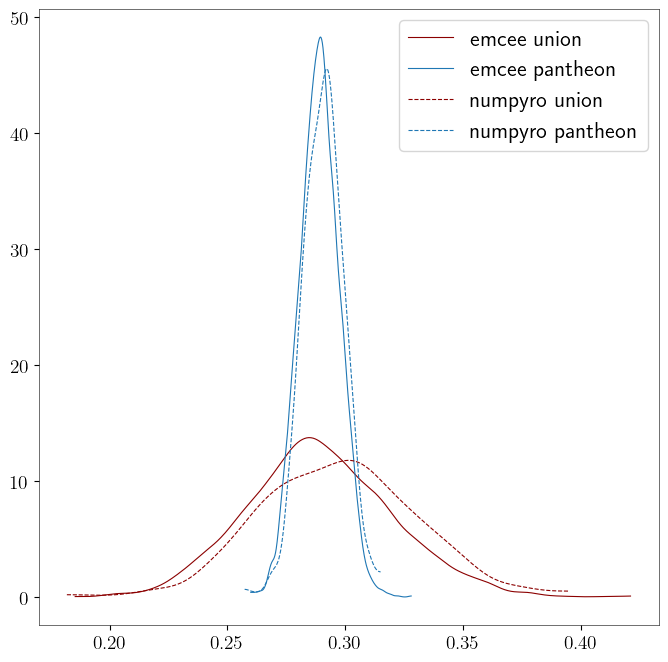

In [236]:
fig1, ax1 = plt.subplots(figsize=(8,8))
plot_results(idata_dict['union_lcdm'], 100, ax=ax1, name='emcee union', dist_kwargs={'color':'darkred'})
plot_results(idata_dict['panth_lcdm'], 100, ax=ax1, name='emcee pantheon', dist_kwargs={'color':'tab:blue'})
plot_results(svi_dict_numpyro['union_lcdm'][0], 0, ax=ax1, name='numpyro union', dist_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed'}})
plot_results(svi_dict_numpyro['panth_lcdm'][0], 0, ax=ax1, name='numpyro pantheon', dist_kwargs={'color':'tab:blue', 'plot_kwargs':{'linestyle':'dashed'}})

The CPL comparison is split up in different parts

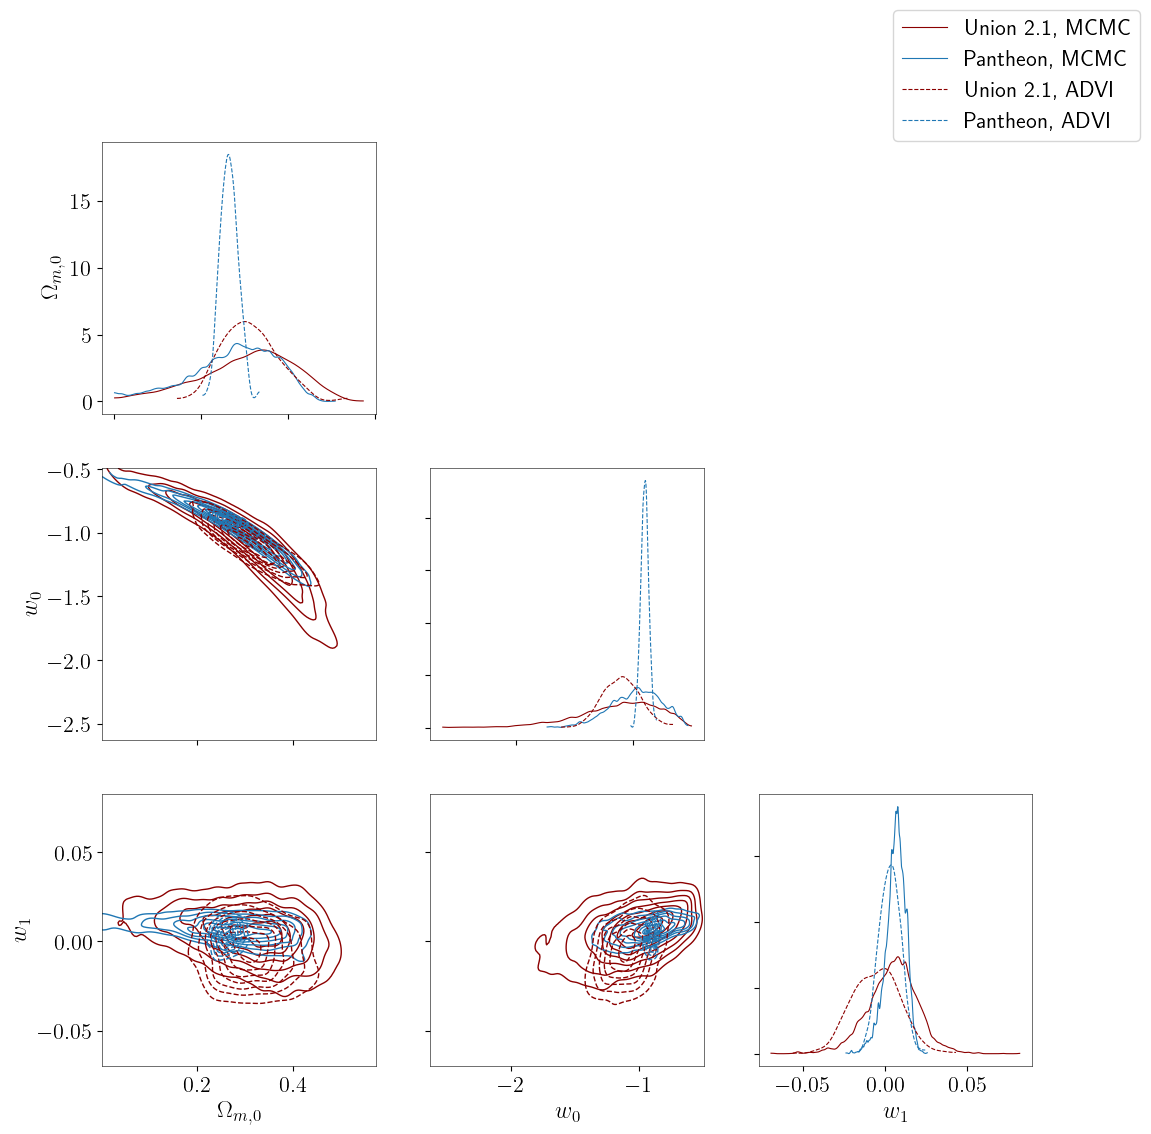

In [194]:
fig2, ax2 = plt.subplots(3,3,figsize=(12,12))
plot_results(idata_dict['union_cpl'], 100, ax=ax2, name='emcee union', 
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'darkred'}},
            marginal_kwargs={"color": "darkred"})
plot_results(idata_dict['panth_cpl'], 100, ax=ax2, name='emcee pantheon',
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'tab:blue'}},
            marginal_kwargs={"color": "tab:blue"})
plot_results(svi_dict_numpyro['union_cpl'][0], 0, ax=ax2, name='numpyro union', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'darkred', "linestyles":"dashed"}},
             marginal_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed'}})
plot_results(svi_dict_numpyro['panth_cpl'][0], 0, ax=ax2, name='numpyro pantheon', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'tab:blue', "linestyles":"dashed"}},
             marginal_kwargs={'color':'tab:blue', 'plot_kwargs':{'linestyle':'dashed'}})


union = mlines.Line2D([], [], color='darkred', label='Union 2.1, MCMC')
panth = mlines.Line2D([], [], color='tab:blue', label='Pantheon, MCMC')
union_d = mlines.Line2D([], [], color='darkred', linestyle='dashed', label='Union 2.1, ADVI')
panth_d = mlines.Line2D([], [], color='tab:blue', linestyle='dashed', label='Pantheon, ADVI')

fig2.legend(handles=(union,panth, union_d,panth_d))

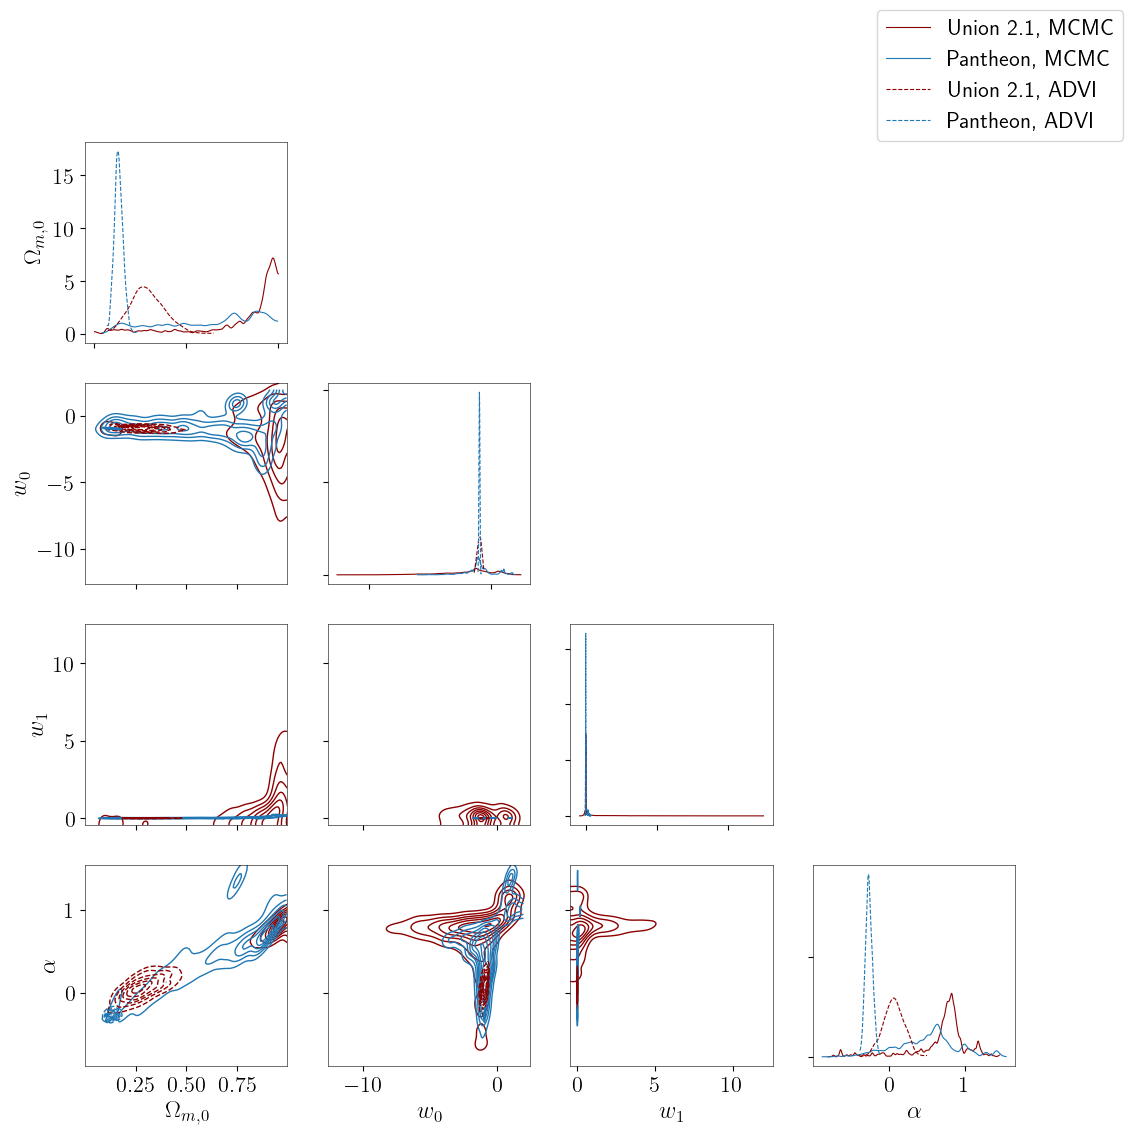

In [237]:
fig3, ax3 = plt.subplots(4,4,figsize=(12,12))
plot_results(idata_dict['union_alpha'], 100, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax3, name='emcee union', 
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'darkred'}},
            marginal_kwargs={"color": "darkred"})
plot_results(idata_dict['panth_alpha'], 100, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax3, name='emcee pantheon',
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'tab:blue'}},
            marginal_kwargs={"color": "tab:blue"})
plot_results(svi_dict_numpyro['union_alpha'][0], 0, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax3, name='numpyro union', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'darkred', "linestyles":"dashed"}},
             marginal_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed'}})
plot_results(svi_dict_numpyro['panth_alpha'][0], 0, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax3, name='numpyro pantheon', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"linewidths":1, "colors":'tab:blue', "linestyles":"dashed"}},
             marginal_kwargs={'color':'tab:blue', 'plot_kwargs':{'linestyle':'dashed'}})

union = mlines.Line2D([], [], color='darkred', label='Union 2.1, MCMC')
panth = mlines.Line2D([], [], color='tab:blue', label='Pantheon, MCMC')
union_d = mlines.Line2D([], [], color='darkred', linestyle='dashed', label='Union 2.1, ADVI')
panth_d = mlines.Line2D([], [], color='tab:blue', linestyle='dashed', label='Pantheon, ADVI')

fig3.legend(handles=(union,panth, union_d,panth_d))

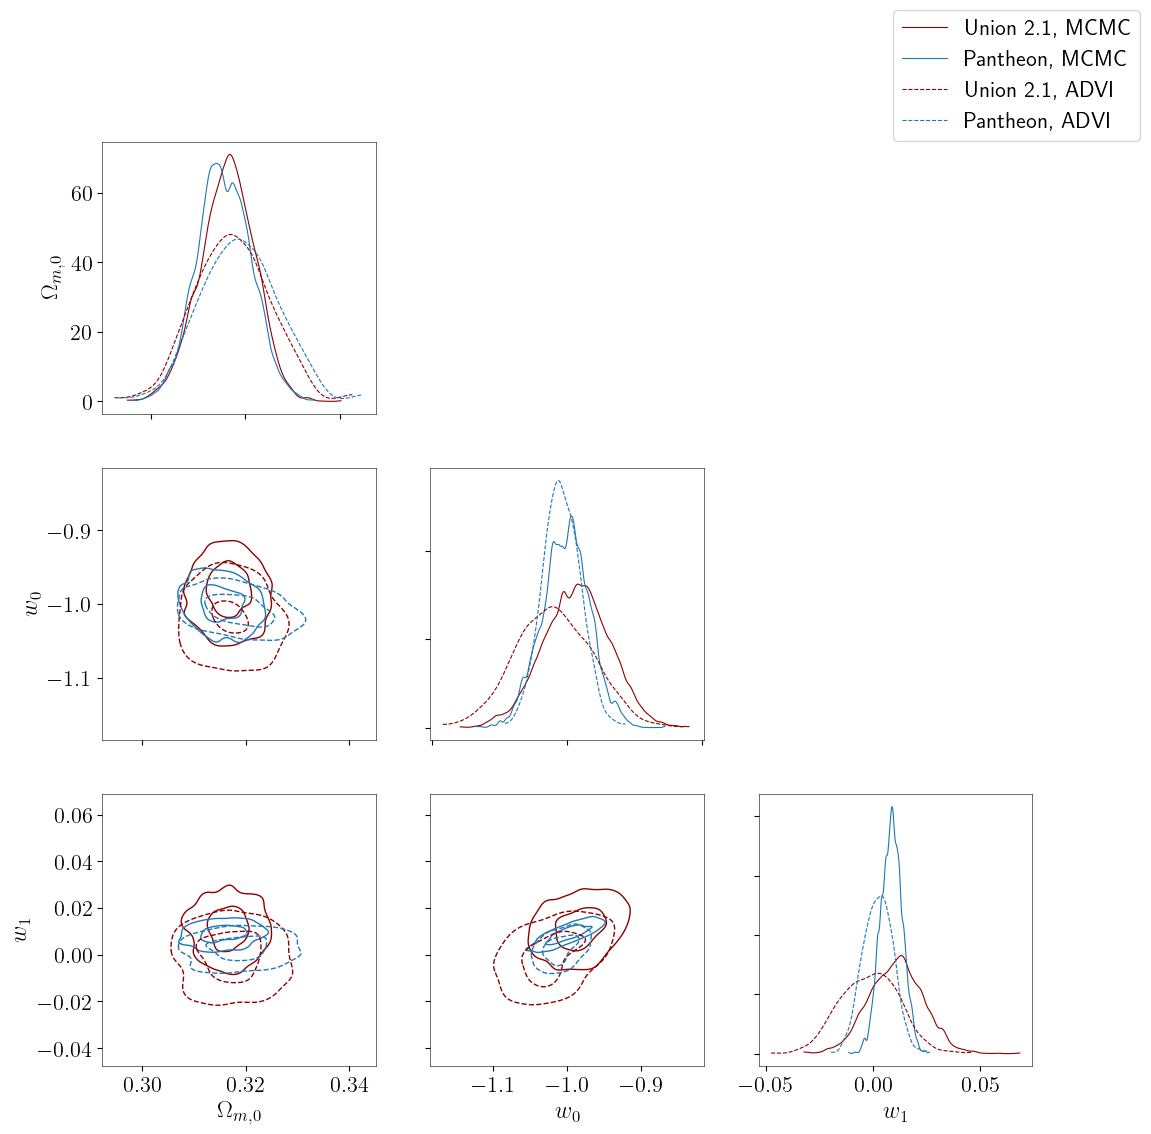

In [238]:
fig4, ax4 = plt.subplots(3,3,figsize=(12,12))
plot_results(idata_dict['union_cpl_planck'], 100, ax=ax4, name='emcee union', 
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'darkred'}},
            marginal_kwargs={"color": "darkred"})
plot_results(idata_dict['panth_cpl_planck'], 100, ax=ax4, name='emcee pantheon',
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'tab:blue'}},
            marginal_kwargs={"color": "tab:blue"})
plot_results(svi_dict_numpyro['union_cpl_planck'][0], 0, ax=ax4, name='numpyro union', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'darkred', "linestyles":"dashed"}},
             marginal_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed'}})
plot_results(svi_dict_numpyro['panth_cpl_planck'][0], 0, ax=ax4, name='numpyro pantheon', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'tab:blue', "linestyles":"dashed"}},
             marginal_kwargs={'color':'tab:blue', 'plot_kwargs':{'linestyle':'dashed'}})


union = mlines.Line2D([], [], color='darkred', label='Union 2.1, MCMC')
panth = mlines.Line2D([], [], color='tab:blue', label='Pantheon, MCMC')
union_d = mlines.Line2D([], [], color='darkred', linestyle='dashed', label='Union 2.1, ADVI')
panth_d = mlines.Line2D([], [], color='tab:blue', linestyle='dashed', label='Pantheon, ADVI')

fig4.legend(handles=(union,panth, union_d,panth_d))

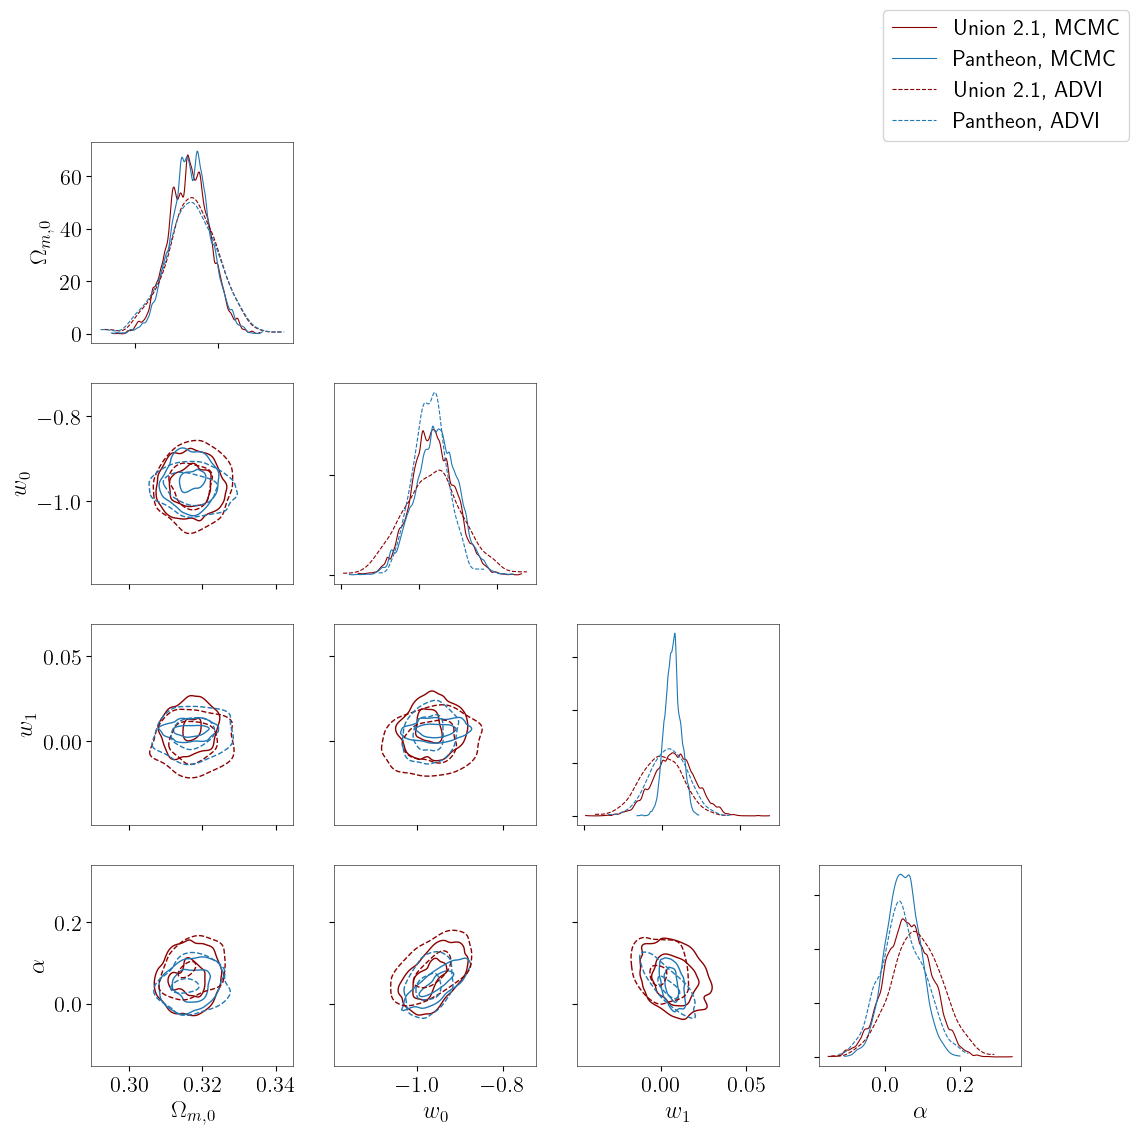

In [239]:
fig5, ax5 = plt.subplots(4,4,figsize=(12,12))
plot_results(idata_dict['union_alpha_planck'], 100, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax5, name='emcee union', 
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'darkred'}},
            marginal_kwargs={"color": "darkred"})
plot_results(idata_dict['panth_alpha_planck'], 100, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax5, name='emcee pantheon',
            kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'tab:blue'}},
            marginal_kwargs={"color": "tab:blue"})
plot_results(svi_dict_numpyro['union_alpha_planck'][0], 0, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax5, name='numpyro union', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'darkred', "linestyles":"dashed"}},
             marginal_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed'}})
plot_results(svi_dict_numpyro['panth_alpha_planck'][0], 0, var_names=[r"$\Omega_{m,0}$", r"$w_0$", r"$w_1$", r"$\alpha$"], ax=ax5, name='numpyro pantheon', 
             kde_kwargs={"contourf_kwargs": {"alpha":0}, "contour_kwargs": {"levels":2, "linewidths":1, "colors":'tab:blue', "linestyles":"dashed"}},
             marginal_kwargs={'color':'tab:blue', 'plot_kwargs':{'linestyle':'dashed'}})

union = mlines.Line2D([], [], color='darkred', label='Union 2.1, MCMC')
panth = mlines.Line2D([], [], color='tab:blue', label='Pantheon, MCMC')
union_d = mlines.Line2D([], [], color='darkred', linestyle='dashed', label='Union 2.1, ADVI')
panth_d = mlines.Line2D([], [], color='tab:blue', linestyle='dashed', label='Pantheon, ADVI')

fig5.legend(handles=(union,panth, union_d,panth_d))